# Motivation

Purpose of this project is to predict the likelihood of making claim. Tensorflow is used to build a machine learning model.

# Libraries

In [102]:
from matplotlib import pyplot as plt

import numpy as np

import os

import pandas as pd

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Add the ../src directory to the Python path
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from src import (
    adjust_column_names)

# Import Data

In [103]:
source_data = pd.read_csv(
    os.path.join('..', 'data', 'insurance_data_sample.csv'),
    sep=',',
    encoding='utf-8',
    parse_dates=['Date'],
    dtype={'Phone': str})

# Preprocess

In [104]:
prep_data = source_data.copy()
prep_data = adjust_column_names(prep_data)

## Select relevant features

In [105]:
FEATURES = ['gender', 'annual_income', 'price_usd', 'body_style', 'amount_paid_for_insurance', 'claim_amount', 'city']

prep_data = prep_data.loc[:, FEATURES]

## Remove outliers

In [106]:
prep_data.query('price_usd >= 8000', inplace=True)

## Convert categorical variables

In [107]:
prep_data = pd.get_dummies(prep_data, columns=['gender', 'city', 'body_style']).astype(int)

# Analyze

In [108]:
prep_data.loc[:, 'is_claim'] = (prep_data.loc[:, 'claim_amount'] > 0).astype(int)
prep_data.drop(['claim_amount'], axis=1, inplace=True)

## Set input and output features

In [109]:
df_X = prep_data.drop(['is_claim'], axis=1).copy()
df_y = prep_data.loc[:, ['is_claim']].copy()

In [110]:
df_y.is_claim.value_counts(dropna=False)

is_claim
0    21511
1     2389
Name: count, dtype: int64

## Normalize

In [111]:
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df_X)

y = df_y.to_numpy()

## Train test split

In [112]:
# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train

In [137]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
# Compile the model
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Binary crossentropy loss for binary classification
    metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  # Large number of epochs to allow early stopping to kick in
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/100
120/120 [==============================] - 2s 8ms/step - loss: 0.4101 - accuracy: 0.8523 - val_loss: 0.3112 - val_accuracy: 0.9082
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3312 - accuracy: 0.8983 - val_loss: 0.3081 - val_accuracy: 0.9082
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3291 - accuracy: 0.8983 - val_loss: 0.3089 - val_accuracy: 0.9082
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3290 - accuracy: 0.8983 - val_loss: 0.3072 - val_accuracy: 0.9082
Epoch 5/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3287 - accuracy: 0.8983 - val_loss: 0.3084 - val_accuracy: 0.9082
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3285 - accuracy: 0.8983 - val_loss: 0.3072 - val_accuracy: 0.9082
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3283 - accuracy: 0.8983 - val_loss: 0.3076 - val_accuracy: 0.9082

## Test

In [138]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test)

150/150 [==============================] - 1s 6ms/step - loss: 0.3288 - accuracy: 0.8990
Test MAE: 0.8989539742469788
150/150 [==============================] - 1s 3ms/step


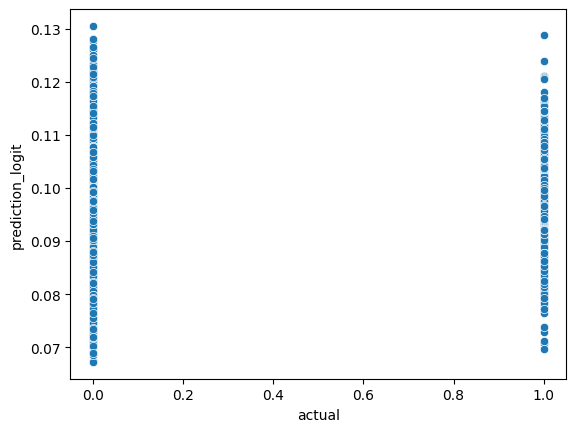

In [139]:
df_comparision = pd.DataFrame(y_test, columns=['actual'])

df_comparision.loc[:, 'prediction_logit'] = predictions

g = sns.scatterplot(df_comparision, x='actual', y='prediction_logit')

plt.show()

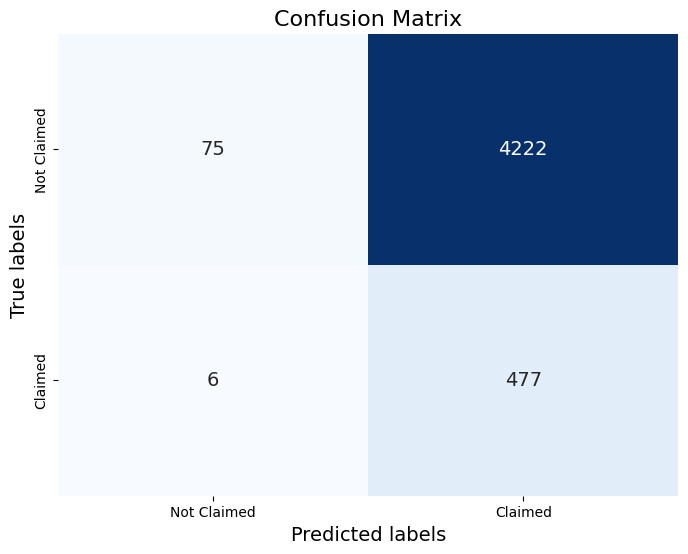

In [140]:
# Calculate the confusion matrix

predictions_binary = (predictions > 0.075).astype(int)
cm = confusion_matrix(y_test, predictions_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'fontsize': 14}, 
            xticklabels=['Not Claimed', 'Claimed'], 
            yticklabels=['Not Claimed', 'Claimed'])
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Discussion

* Dataset is imbalance. It should be balanced.
* Where claim likelihood > 0.075, output should be considered as 'Claimed'
* Currently, it creates a lot of false positive. Model should be improved.
* Alternative machine learning models such as random forest, bootstrap aggregation techniques should be tried.